In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

import torch.cuda

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as func
from torch.optim import lr_scheduler
from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
train_on_gpu = torch.cuda.is_available()
DEVICE = torch.device("cpu")

if not train_on_gpu:
    print('CUDA не доступна. Обучение проходит на CPU')
else:
    DEVICE = torch.device("cuda")
    print('CUDA доступна. Обучение проходит на GPU')

CUDA доступна. Обучение проходит на GPU


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
RESCALE_SIZE = 224

In [ ]:
#!kaggle competitions download -c journey-springfield
#!cp -r "../input/journey-springfield" "./"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/

MyDrive  Othercomputers


In [ ]:
!ls -l /content/gdrive/MyDrive/journey-springfield.zip

-rw------- 1 root root 546224286 Feb 25 22:03 /content/gdrive/MyDrive/journey-springfield.zip


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

# Разделение датасета

Создадим переменные, содержащие пути до папок train/test

In [ ]:
# test_path = Path('../input/journey-springfield/testset/testset')
# train_path = Path('../input/journey-springfield/train/simpsons_dataset')

In [ ]:
from pathlib import Path
test_path = Path('testset/testset')
train_path = Path('train/simpsons_dataset')

In [ ]:
train_val_files = list(train_path .rglob('*.jpg'))
test_files = list(test_path .rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


Отсортируем файлы и дадим класс (имя) каждому изображению из теста

In [ ]:
train_val_files = sorted(list(train_path.rglob('*.jpg')))
train_val_labels = [i.parent.name for i in train_val_files]

In [ ]:
test_val_files = sorted(list(test_path.rglob('*.jpg')))
test_val_labels = [i.parent.name for i in test_val_files]

# Анализ данных

Рассмотрим на распределение классов

In [ ]:
df = pd.DataFrame(train_val_labels, columns=['name'])
df['count'] = 1
df = df.groupby('name').count().sort_values('count')

Проверим как выглядит таблица. Выведем случайные строки

In [ ]:
df.sample(n=7)

,count
name,
martin_prince,71
principal_skinner,1194
abraham_grampa_simpson,913
patty_bouvier,72
gil,27
kent_brockman,498
edna_krabappel,457


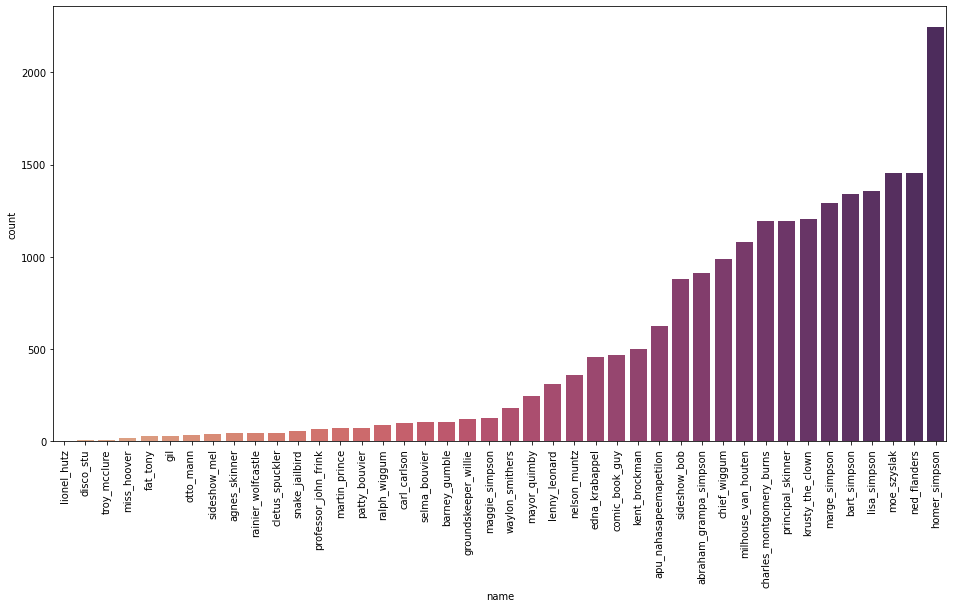

In [ ]:
plt.figure(figsize=(16,8))
sns.barplot(x=df.index , y='count', data=df, palette='flare')
plt.xticks(rotation=90)
plt.show()

Как мы видим наши классы несбалансированные, что вполне ожидаемо. Самый "популярный" герой - Гомер Симпсон

Посмотрим на рандомные 4 фотографии из датасета

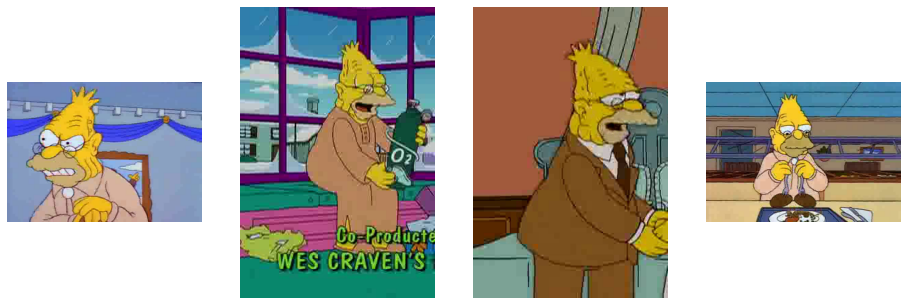

In [ ]:
file_path = [train_val_files[13], train_val_files[4], train_val_files[777], train_val_files[666]]
fig = plt.figure(figsize=(16, 8))
rows = 1
columns = 4
for i in range (len(file_path)):
    fig.add_subplot(rows, columns, i+1)
    image = Image.open(file_path[i])
    plt.imshow(image)
    plt.axis('off')

Как мы видим: все фотографии разного размера, нужно это исправить

# Подготовка данных
<br>
Улучшим ситуацию с дисбалансом классов с помощью аугментации изображений, допустим в каждом классе у нас не менее 1500 изображений

In [ ]:
df['to_add'] = df['count'].apply(lambda x: 1500 - x if x < 1500 else 0)

Столбец one_iteration покажет нам, сколько новых изображений мы должны сделать из одного исходного изображения.

In [ ]:
import math

df['one_iteration'] = df.apply(lambda x: math.ceil(x['to_add'] / x['count']), axis=1)
df

,count,to_add,one_iteration
name,,,
lionel_hutz,3,1497,499
disco_stu,8,1492,187
troy_mcclure,8,1492,187
miss_hoover,17,1483,88
fat_tony,27,1473,55
gil,27,1473,55
otto_mann,32,1468,46
sideshow_mel,40,1460,37
agnes_skinner,42,1458,35


# Аугментация

Посмотрим как работает аугментация: http://pytorch.org/vision/master/auto_examples/plot_transforms.html

In [ ]:
augmenters = {
    'Crop': transforms.Compose([
                                transforms.Resize(size=224),
                                transforms.RandomCrop(174)
                                ]),
    'Rotation': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'Perspective': transforms.RandomPerspective(distortion_scale=0.6, p=1.0)
}

In [ ]:
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

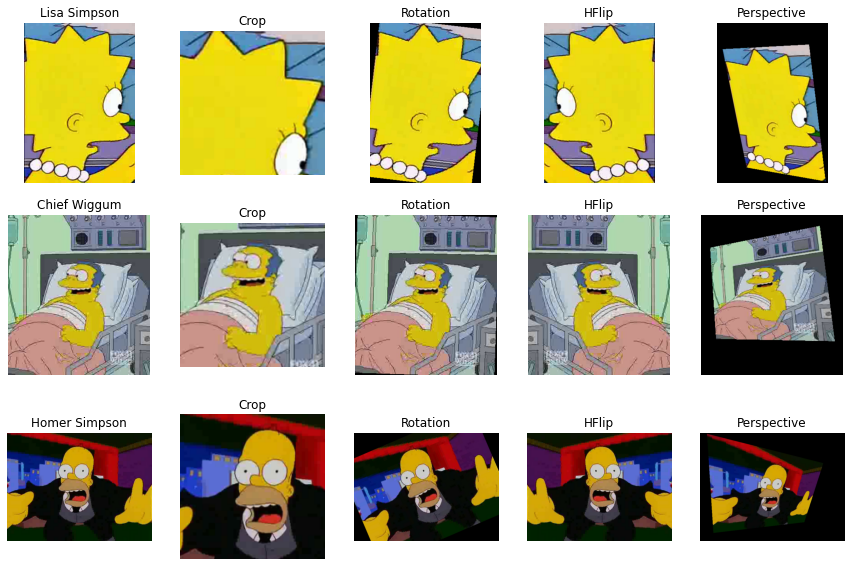

In [ ]:
n_examples = 3 # отображение 3х изображений

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(15, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files))) # берем рандомный индекс фотографии
    img_orig = load_image(train_val_files[random_character]) # подгружаем его
    img_label = train_val_files[random_character].parent.name # подтягиваем лейбл фотографии

    img_label = " ".join(map(lambda x: x.capitalize(),img_label.split('_'))) # делаем наш лейбл читаемым
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()): # вывод результатов аугментации
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

Применим аугментацию для изображений и сохраним результаты в папке train

In [ ]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.RandomCrop(224)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augmentations,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)

Рассчитаем веса для классов. Менее популярный класс будет иметь меньший вес.

In [ ]:
from collections import Counter

class_count = Counter(train_dataset.targets)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (data, label) in enumerate(tqdm(train_dataset)):
    class_weight = class_weights[label]
    sample_weights[i] = class_weight
    
N = max(class_count.values()) * len(class_count)  # fit to max
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=2)

100%|██████████| 20933/20933 [02:04<00:00, 167.76it/s]


Посмотрим теперь на распределение классов

In [ ]:
count = Counter()
for data, labels in tqdm(train_loader):
    count += Counter(labels.tolist())
print(sum(count.values()), count)

100%|██████████| 1474/1474 [08:32<00:00,  2.88it/s]

94332 Counter({34: 2374, 7: 2338, 14: 2311, 37: 2310, 18: 2309, 25: 2295, 24: 2293, 23: 2291, 22: 2290, 3: 2285, 35: 2282, 1: 2281, 8: 2280, 6: 2279, 2: 2275, 19: 2270, 9: 2265, 4: 2262, 36: 2260, 15: 2260, 39: 2255, 32: 2248, 28: 2246, 30: 2245, 13: 2242, 26: 2238, 21: 2234, 41: 2225, 10: 2218, 31: 2216, 0: 2215, 20: 2208, 5: 2205, 33: 2197, 38: 2197, 16: 2190, 17: 2187, 27: 2183, 29: 2160, 12: 2145, 40: 2142, 11: 2126})


Как мы видим, нам удолось улучшить ситуацию с несбалансированными данными

# Построение нейросети

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = func.softmax(outputs, dim=-1).argmax(-1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def train(model, loss, optimizer, scheduler, epochs, batch_size):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))

    return history

In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=a02fb889967e2bf8343228ef4b5f293a18491c2e5a0e090c84cac161df7bd7c1
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


In [ ]:
# Размер входных свойств у классификатора модели - 1408
num_features = 1408
# Заменяем Fully-Connected слой на наш линейный классификатор
n_classes = len(np.unique(train_val_labels))
model.classifier = nn.Linear(num_features, n_classes)

# Использовать ли GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - AdamW
import torch.optim as optim
optimizer_ft = optim.AdamW(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
history = train(model=model, loss=loss_fn, optimizer=optimizer_ft, scheduler=exp_lr_scheduler, epochs=3, batch_size=64) # Можно и больше эпох, но коллаб не тянет :(

epoch:  33%|███▎      | 1/3 [16:56<33:52, 1016.33s/it]


Epoch 001 train_loss: 0.0144 train_acc 0.9965


epoch:  67%|██████▋   | 2/3 [33:55<16:57, 1017.74s/it]


Epoch 002 train_loss: 0.0103 train_acc 0.9974


epoch: 100%|██████████| 3/3 [50:49<00:00, 1016.45s/it]


Epoch 003 train_loss: 0.0074 train_acc 0.9981


In [ ]:
loss, acc = zip(*history)

Посмотрим на график лосс-функции

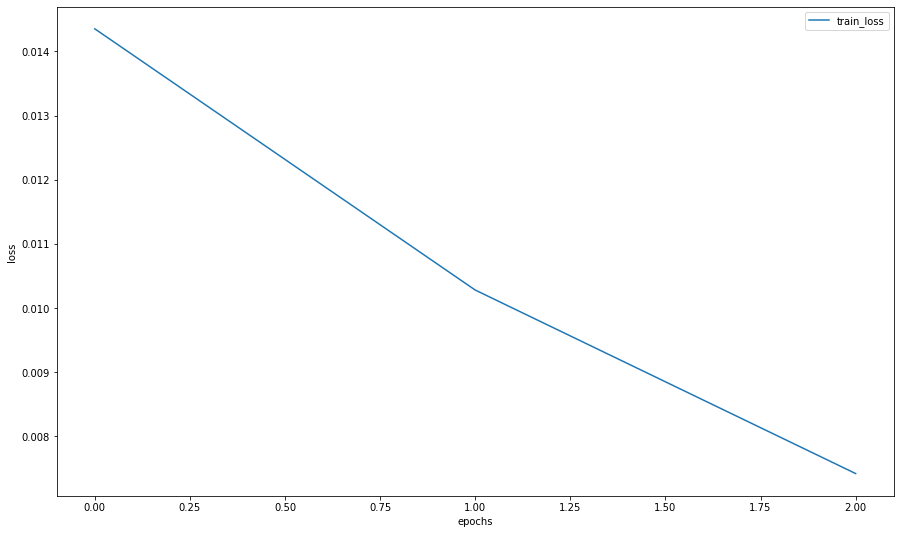

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = func.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
test_dataset = TestDataset(test_val_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=256)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

# BaseLine Score и сохранение результатов

In [ ]:
my_submit = pd.DataFrame({
    "Id": test_filenames,
    "Expected": preds
})

In [ ]:
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv("submission.csv", index=False)